# Seeing Through the Rock: Evaluating Bias and Uncertainty in Visual Mineral Estimation

#### GEOL 503 final project by Yakov Yermakov

This project idea emerged from reviewing numerous student assignment submissions in which they estimated mineral abundances in both hand samples and thin sections. This task is practically valuable because it helps students understand the potential biases and limitations of visual mineral identification, especially in field settings where thin sections and microscopes aren't available.  
**The main goals** of this project are to:   
1. Evaluate the extent to which students miscalculate major mineral abundances.  
1. Identify whether individuals have consistent biases — such as overestimating or underestimating specific minerals.
1. Detect common trends in misidentification across multiple students. 
1. Quantify the uncertainty in visual mineral estimation in hand samples compared to thin section analysis.

**The core dataset** consists of four slightly different granite samples and one dike  from southeastern Missouri. For each sample (hand sample and thin section), students provided visual estimates of the modal abundances of major minerals. These will be compared against a "true" dataset derived from 100-point manual point-count analysis of the corresponding thin sections. A secondary dataset will include estimates from a previous cohort of students. This may help to reveal whether instructional differences (e.g., different teachers) influence biases or whether the trends hold consistently across groups.  
Data will be analyzed using Python. _Pyrolite_ package will be used to illustrate patterns and discrepancies in mineral estimation on ternary plots. 


In [4]:
#import packages: matplotlib, numpy, pands, pyrolite or plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrolite.plot.templates import QAP
from pyrolite.util.plot.helpers import plot_stdev_ellipses

In [5]:
import warnings
warnings.filterwarnings("ignore") #just to remove this pile of warnings while making plots

In [6]:
#import csv file, convert data to data frame, recalculate %'s to 100%
df = pd.read_csv('QAP_dataset.csv')
qap_cols = ['Q', 'A', 'P']
percent = 100
df[qap_cols] = df[qap_cols].div(df[qap_cols].sum(axis=1), axis=0) * percent #normalizing dataset for ternary plot
df

,Student,Year,sample,type,Q,A,P
0,A,2025,Graniteville Granite,HS,NaN,NaN,NaN
1,B,2025,Graniteville Granite,HS,18.811881,62.376238,18.811881
2,C,2025,Graniteville Granite,HS,20.000000,70.000000,10.000000
3,D,2025,Graniteville Granite,HS,21.052632,78.947368,0.000000
4,E,2025,Graniteville Granite,HS,NaN,NaN,NaN
...,...,...,...,...,...,...,...
110,J,2017,Knob Lick Dike,TS,20.000000,40.000000,40.000000
111,K,2024,Knob Lick Dike,TS,24.719101,43.820225,31.460674
112,L,2024,Knob Lick Dike,TS,NaN,NaN,NaN
113,M,2024,Knob Lick Dike,TS,17.647059,52.941176,29.411765


In [7]:
#let's see how our data looks like in general.
#here's the function that will plot all 6 samples together
def plot_qap_simple(df):
    samples = df["sample"].unique() # extracting each sample name
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten() #need 1d array for for function
    axs_tern = axs[0:5]
    for i, sample in enumerate(samples): #this is how I build each plot
        ax = axs_tern[i]
        subset = df[df["sample"] == sample]
        #We have "true" point from point counting, Hand Sample estimates and Thin Section estimates:
        true_point = subset[subset["Student"] == "TRUE"]
        hs = subset[(subset["type"] == "HS") & (subset["Student"] != "TRUE")]
        ts = subset[(subset["type"] == "TS") & (subset["Student"] != "TRUE")]

        # Default template QAP diagram for felsic rocks.
        ax = QAP(ax=ax, linewidth=0.4, add_labels=False, color='gray') #No labels because it's too messy & we have volcanic rock sample
        
        hs_plot = ax.scatter(hs["Q"], hs["A"], hs["P"], c="darkgrey", marker = '*', label="HS", s=250) #hand samples
        ts_plot = ax.scatter(ts["Q"], ts["A"], ts["P"], c="tomato", marker = '*', label="TS", s=250, edgecolors='black') #thin sections
        true_plot = ax.scatter(true_point["Q"], true_point["A"], true_point["P"], c="blue", marker=".", s=400, label="TRUE") #"true" point

        ax.set_title(f"{sample}", fontsize=20) #sample name for each plot
    
    # Use last subplot for legend
    handles = [hs_plot, ts_plot, true_plot]
    labels = ["Hand sample", "Thin section", "True point"]
    axs[5].axis('off')  # Hide the axis
    axs[5].legend(handles=handles, labels=labels, loc='center', fontsize=24, title="Legend", title_fontsize=26, bbox_to_anchor=(0.5, 0.9))        

    
    plt.tight_layout()
#    plt.savefig("QAP_simple_plot.svg")
    plt.show()

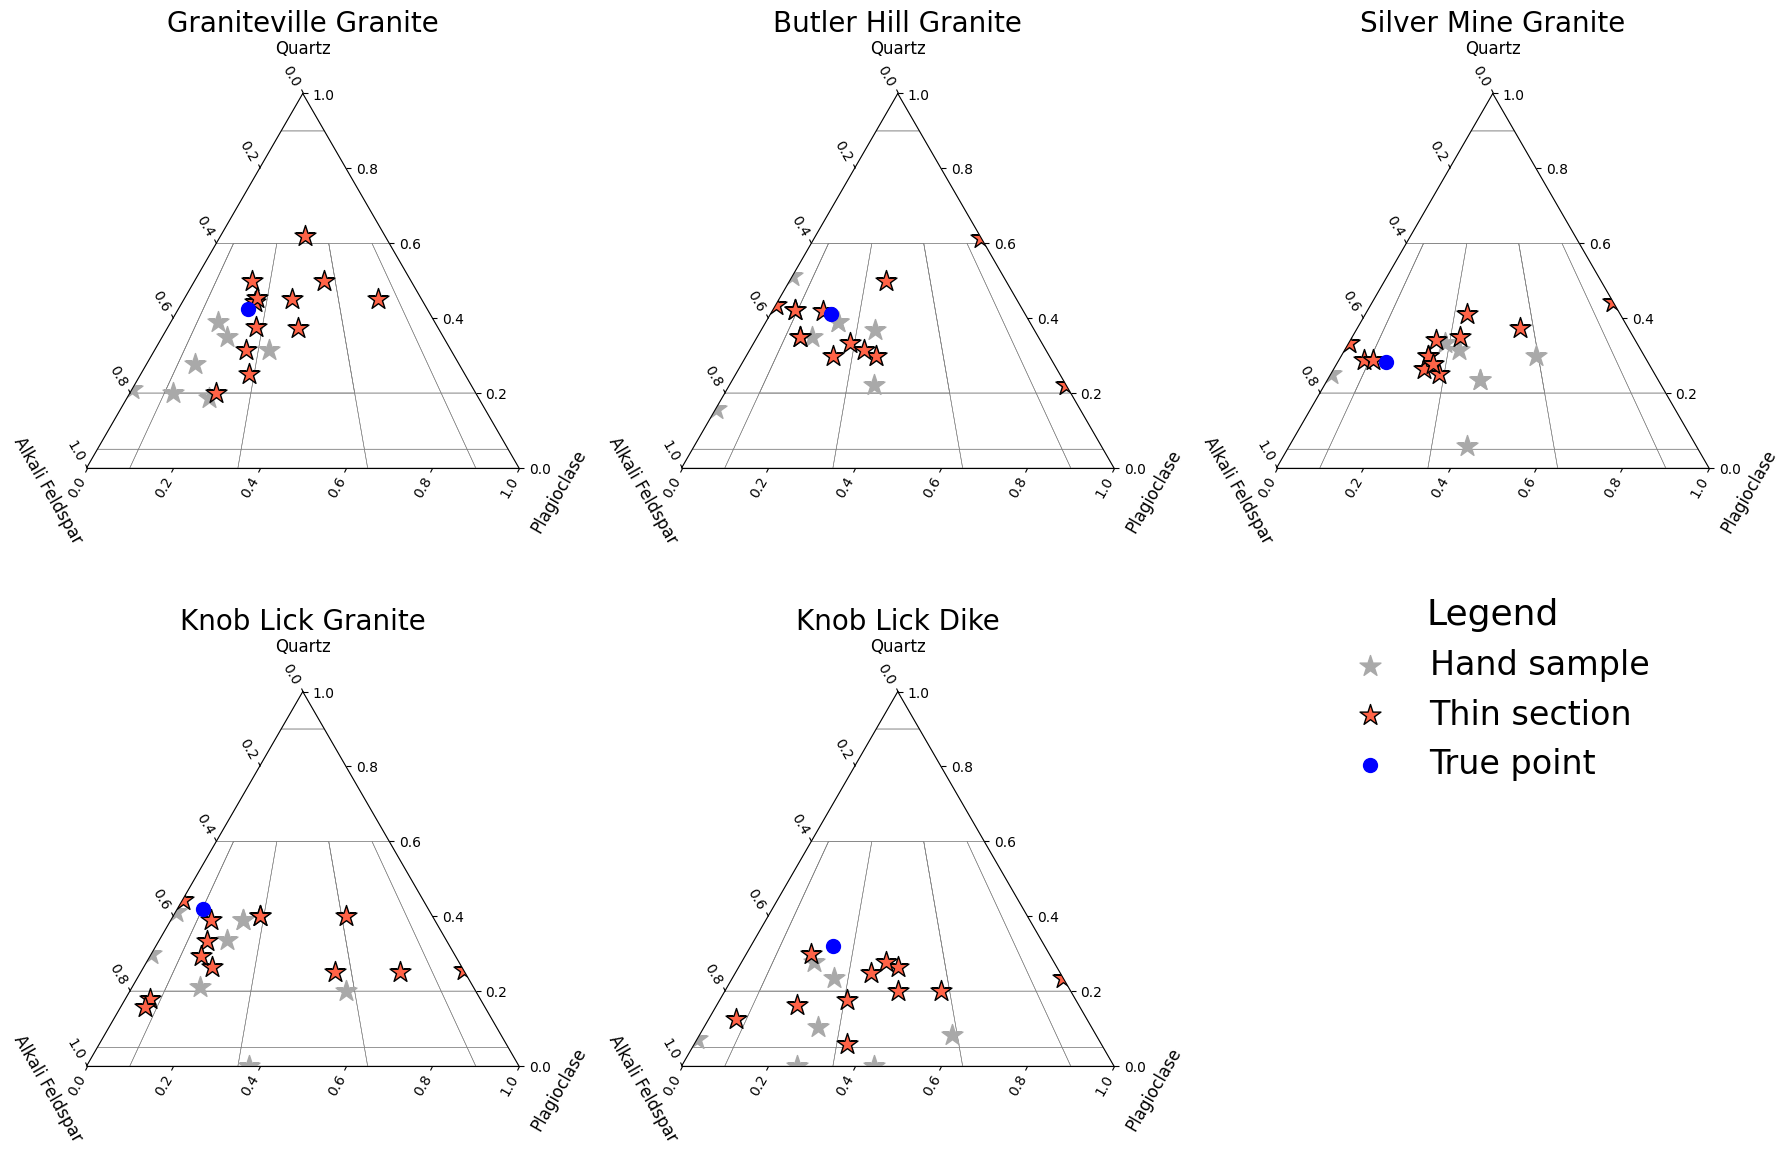

In [8]:
plot_qap_simple(df)

Cool, but how about more details. I would like to see point counting uncertainty, separate students by year (different colour by sample type as above, different markers by year), and in addition I would like to add dashed lines that will connect hand sample and thin section estimates for the same student in each sample. Might be overloaded, but let's see:

In [10]:
#We have point counting analysis for each sample, let's see what is the standart error for this data:
counts = pd.read_csv("point_counts.csv") 
counts = counts.drop(columns=["Point #"]) #removing first column
minerals = ['Q', 'A', 'P']
results = []

for sample in counts.columns: # Process each sample 
    counts_tot = counts[sample].value_counts()
    sample_data = {"sample": sample}
    
    for m in minerals: #obtain se for each mineral in sample
        count = counts_tot.get(m, 0) #counts for m mineral
        proportion = count / sum(counts_tot[minerals]) #normalized proportion for each mineral
        se = np.sqrt(proportion * (1 - proportion) / sum(counts_tot[minerals])) #standard error equation
        sample_data[f"{m}_σ"] = se * 100  #convert to %
    
    results.append(sample_data)

error_counts = pd.DataFrame(results) #convert it into dataframe
error_counts


,sample,Q_σ,A_σ,P_σ
0,Graniteville Granite,4.967173,4.950546,3.699527
1,Butler Hill Granite,5.097400,5.160423,3.595773
2,Silver Mine Granite,4.807467,5.217326,3.383166
3,Knob Lick Granite,5.065542,5.127333,2.495659
4,Knob Lick Dike,4.769050,5.129608,4.020649


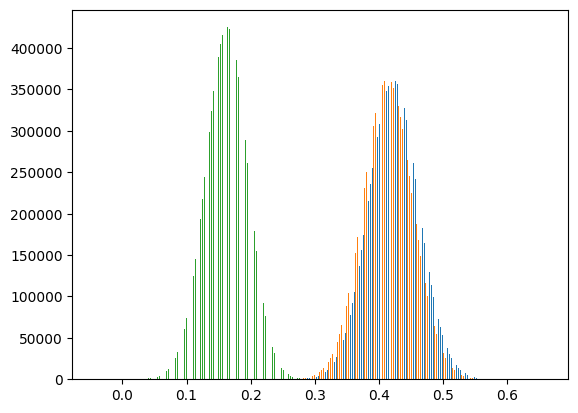

array([-0.00066045, -0.00610842, -0.02158175, -0.0109885 , -0.01943168,
       -0.0394151 , -0.00059215, -0.00774973, -0.00776045, -0.01848481,
       -0.00220461, -0.01109676, -0.02795428, -0.01650366, -0.01638007,
       -0.00118387, -0.00707879, -0.00953101, -0.01210008, -0.00673558,
       -0.02811657, -0.00590478, -0.00111733, -0.00883266, -0.04333299,
       -0.00895851, -0.0120335 , -0.00881336, -0.00909726, -0.02255549,
       -0.00024249, -0.02297623, -0.0033729 , -0.00189618, -0.0355685 ,
       -0.01268135, -0.02449584, -0.00601481, -0.00655307, -0.00326449,
       -0.00210005, -0.00391459, -0.00579515, -0.01440467, -0.01417678,
       -0.02315419, -0.02652041, -0.01112612, -0.02401511, -0.00222353,
       -0.00630484, -0.00338683, -0.00475335, -0.00240705, -0.00246947,
       -0.00068662, -0.01777449, -0.00331745, -0.00841566, -0.00098319,
       -0.01055112, -0.01013332, -0.01187713])

In [319]:
# this code is for test, to see how multivariate_normal works
test_nMC = 10000000
mean = np.array([42.4,	41.4,	16.16]) # true point
cov = np.diag([4.967173**2, 4.950546**2, 3.699527**2]) #Covariance matrix, standard error is the square root of the variance
points = np.random.multivariate_normal(mean = mean, cov = cov,  size = test_nMC)
points = points / points.sum(axis=1, keepdims=True)
fig, ax = plt.subplots()
ax.hist(points[:,:],bins = 200)
plt.show()
points[points <0]

In [299]:
#here's the function that will plot all 6 samples together + point counting uncertainty
def plot_qap_adv(df, errors_df=None, nMC = 100): #big size makes these functions run forever
    
    #same lines as previous function:
    samples = df["sample"].unique()
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten() 
    axs_tern = axs[0:5]
    for i, sample in enumerate(samples):
        ax = axs_tern[i]
        subset = df[df["sample"] == sample]
        true_point = subset[subset["Student"] == "TRUE"]
        hs = subset[(subset["type"] == "HS") & (subset["Student"] != "TRUE")]
        ts = subset[(subset["type"] == "TS") & (subset["Student"] != "TRUE")]       
        ax = QAP(ax=ax, linewidth=0.4, add_labels=False, color='gray') 
        
        #Here we add more edits to our plot:
        chem = ["Q", "A", "P"]
        q, a, p = true_point[chem].values[0]
        true_plot = ax.scatter(q, a, p, c="blue", marker=".", s=250, label="True Value") #point counting "true" point
        # Plot incertainty ellipses

        err_row = errors_df[errors_df["sample"] == sample]
        dq, da, dp = err_row[["Q_σ", "A_σ", "A_σ"]].values[0]
        # I need cloud of points out of my standard error data
        mean = np.array([q, a, p]) # true point
        #Covariance matrix, standard error is the square root of the variance
        cov = np.diag([dq**2, da**2, dp**2]) 
        
        # Generate points from the multivariate normal distribution
        points = np.random.multivariate_normal(mean, cov, nMC) 
        points = points / points.sum(axis=1, keepdims=True)  # enforce closure
        points_df = pd.DataFrame(np.vstack(points))
        
        points_df.columns = chem
        kwargs = dict(ax=ax, bins=100, axlabels=False) #taken from pyrolite template
        points_df.loc[:, chem].pyroplot.density(cmap="Blues", vmin=0.05, **kwargs) #this makes cloud of points
        points_df.loc[:, chem].pyroplot.density( 
            contours=[0.95],
            cmap="Blues_r", #I need reversed colourmap here - it starts with dark color so my contour will be visible
            contour_labels={0.95: "2σ"},
            **kwargs
        ) #this makes contoured uncertainty
        #After that, I can add my other data so it will be visible above the cloud of true point deviation
        hs_plot = ax.scatter(hs["Q"], hs["A"], hs["P"], c="darkgrey",marker = '*', label="HS", s=250) #hand samples
        ts_plot = ax.scatter(ts["Q"], ts["A"], ts["P"], c="tomato",marker = '*', label="TS", s=250, edgecolors='black') #thin sections
        
        ax.set_title(f"{sample}", fontsize=20) #sample name for each plot
    # Use last subplot for legend
    handles = [hs_plot, ts_plot, true_plot]
    labels = ["Hand sample", "Thin section", "True with uncertainty"]
    axs[5].axis('off')  # Hide the axis
    axs[5].legend(handles=handles, labels=labels, loc='center', fontsize=24, title="Legend", title_fontsize=26, bbox_to_anchor=(0.5, 0.9))        
        
    plt.tight_layout()
#    plt.savefig("QAP_uncert_plot.svg")
    plt.show()

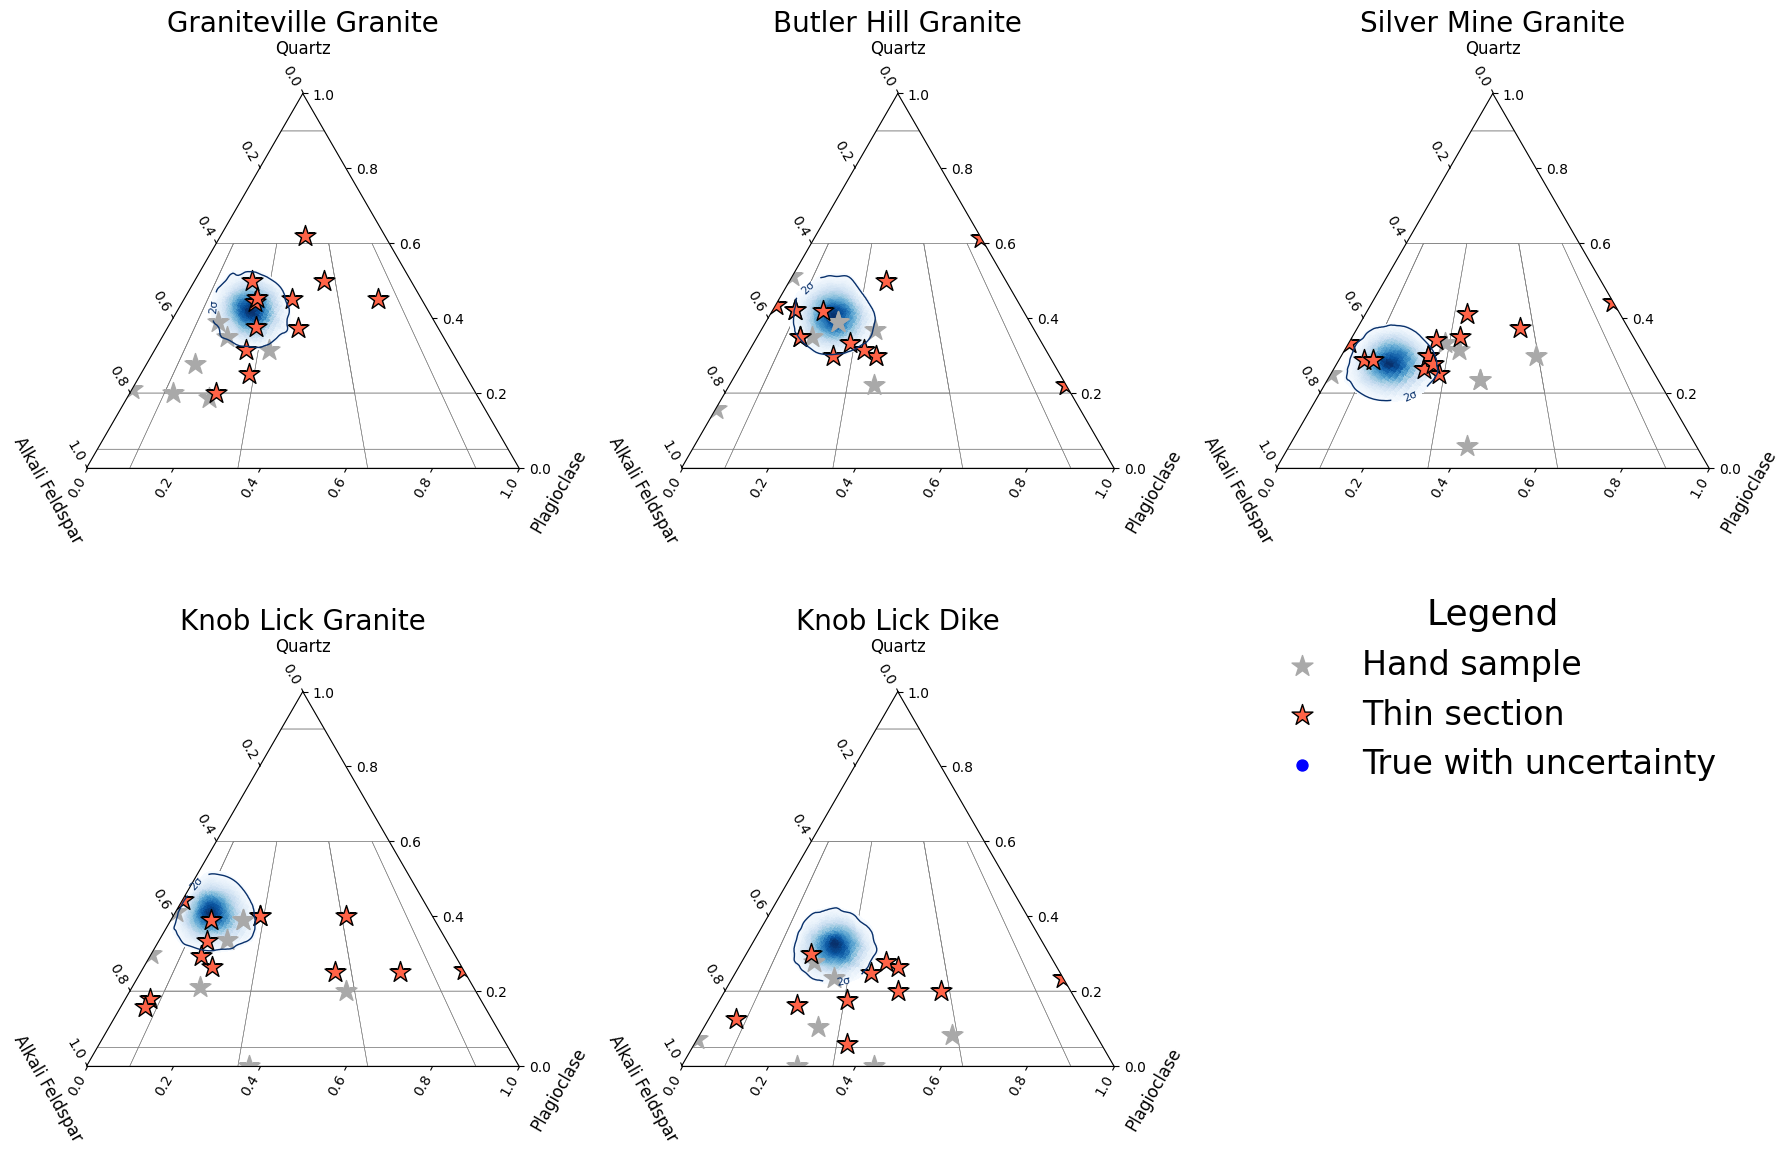

In [301]:
plot_qap_adv(df, error_counts, nMC = 10000)

In [14]:
#Let's make this function more complicated - divide students by year and connect HS and TS estimates for same students
def plot_qap_very_adv(df, errors_df=None, nMC = 100):
    #That's all the same as above
    samples = df["sample"].unique()
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten() 
    axs_tern = axs[0:5]
    for i, sample in enumerate(samples): 
        ax = axs_tern[i]
        subset = df[df["sample"] == sample]
 
        true_point = subset[subset["Student"] == "TRUE"]
        hs = subset[(subset["type"] == "HS") & (subset["Student"] != "TRUE")]
        ts = subset[(subset["type"] == "TS") & (subset["Student"] != "TRUE")]

        ax = QAP(ax=ax, linewidth=0.4, add_labels=False, color='gray') #

        
        chem = ["Q", "A", "P"]
        q, a, p = true_point[chem].values[0]
        ax.scatter(q, a, p, c="blue", marker=".", s=250, label="True with uncertainty")
        err_row = errors_df[errors_df["sample"] == sample]
        dq, da, dp = err_row[["Q_σ", "A_σ", "P_σ"]].values[0]
        mean = np.array([q, a, p])
        cov = np.diag([dq**2, da**2, dp**2])
        
        points = np.random.multivariate_normal(mean, cov, nMC) 
        points_df = pd.DataFrame(np.vstack(points))
        points_df.columns = chem
        kwargs = dict(ax=ax, bins=100, axlabels=False) 
        points_df.loc[:, chem].pyroplot.density(cmap="Blues", vmin=0.05, **kwargs) 
        points_df.loc[:, chem].pyroplot.density( 
            contours=[0.95],
            cmap="Blues_r",
            contour_labels={0.95: "2σ"},
            **kwargs
        )
        
        #New lines of code below:
        # Define markers for different years
        year_marker_dict = dict(zip(sorted(df["Year"].unique()), ['x', '.', '*'])) #This builds a dictionary for years paired with marker
        
        # Plot each point with color by type and marker by year
        for _, row in hs.iterrows():
            ax.scatter(row["Q"], row["A"], row["P"],
                       c="darkgrey", marker=year_marker_dict[row["Year"]],
                       label=f"HS {row['Year']}", s = 250)

        for _, row in ts.iterrows():
            ax.scatter(row["Q"], row["A"], row["P"],
                       c="tomato", marker=year_marker_dict[row["Year"]],
                       label=f"TS {row['Year']}", s = 250, edgecolors='black')

        # Connect HS and TS points for the same student
        student_ids = set(hs["Student"]).intersection(set(ts["Student"])) #so I get IDs where both HS and TS were estimated
        for student in student_ids:
            hs_point = hs[hs["Student"] == student][["Q", "A", "P"]].values
            ts_point = ts[ts["Student"] == student][["Q", "A", "P"]].values
            line = np.vstack([hs_point[0], ts_point[0]])
            ax.plot(line[:, 0], line[:, 1], line[:, 2],
                    linestyle='dashed', color='gray', linewidth=1, alpha=0.9)

        #same as before below
        
        ax.set_title(f"{sample}", fontsize=20)
      
        # Custom legend to avoid repeats
#        handles, labels = ax.get_legend_handles_labels()
#        by_label = dict(zip(labels, handles))
#        ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[5].axis('off')  # Hide the axis
    axs[5].legend(by_label.values(), by_label.keys(), loc='center', fontsize=24, title="Legend", title_fontsize=26, bbox_to_anchor=(0.5, 0.8))        
        
    plt.tight_layout()
#    plt.savefig("QAP_uncert_years_plot.svg")
    plt.show()

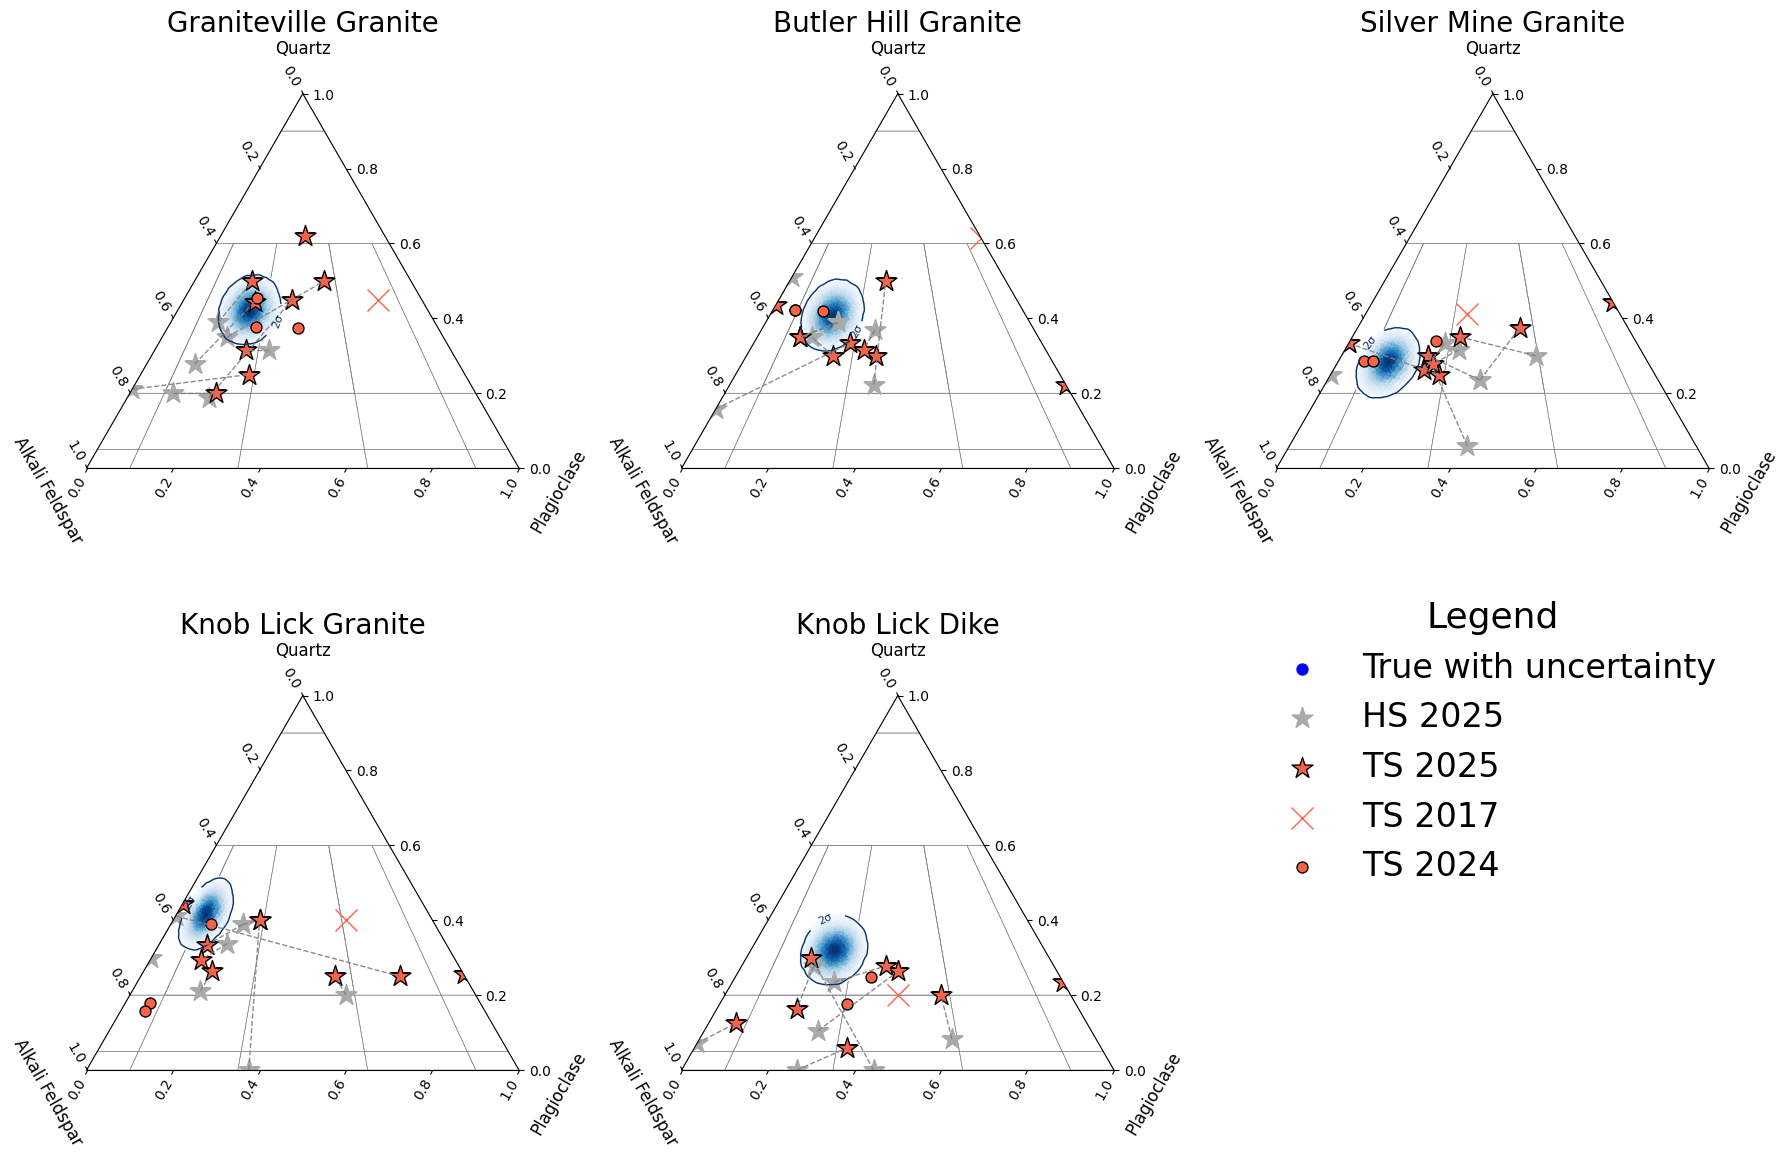

In [15]:
plot_qap_very_adv(df, error_counts, nMC = 100000) 

Ok, This is all we can get from ternary plots. Now let's quantify how students miscalculate mineral abundances and what it depends of:

In [17]:
#First, let's quantify how students make errors in general

samples = df["sample"].unique()
student_errors = []
for i in samples:
    subset = df[df["sample"] == i]
    true_point = subset[subset["Student"] == "TRUE"]
    chem = ["Q", "A", "P"]
    q, a, p = true_point[chem].values[0]
    student_points = subset[(subset["Student"] != "TRUE")]
    for _, row in student_points.iterrows():
        student_errors.append({
            "Student": row["Student"],
            "Year": row["Year"],
            "Sample": i,
            "type": row["type"],
            "Q_dev": (row["Q"] - q), #if deviation > 0 - student overestimated mineral in this sample
            "A_dev": (row["A"] - a),
            "P_dev": (row["P"] - p)
        })

student_errors_df = pd.DataFrame(student_errors)
print(student_errors_df)
    

    Student  Year                Sample type      Q_dev      A_dev      P_dev
0         A  2025  Graniteville Granite   HS        NaN        NaN        NaN
1         B  2025  Graniteville Granite   HS -23.612361  20.962096   2.650265
2         C  2025  Graniteville Granite   HS -22.424242  28.585859  -6.161616
3         D  2025  Graniteville Granite   HS -21.371611  37.533227 -16.161616
4         E  2025  Graniteville Granite   HS        NaN        NaN        NaN
..      ...   ...                   ...  ...        ...        ...        ...
105       I  2025        Knob Lick Dike   TS  -4.222222 -10.111111  14.333333
106       J  2017        Knob Lick Dike   TS -12.000000  -9.000000  21.000000
107       K  2024        Knob Lick Dike   TS  -7.280899  -5.179775  12.460674
108       L  2024        Knob Lick Dike   TS        NaN        NaN        NaN
109       M  2024        Knob Lick Dike   TS -14.352941   3.941176  10.411765

[110 rows x 7 columns]


In [18]:
# Calculate mean deviation per Sample and Type (HS/TS)
sample_order = student_errors_df["Sample"].drop_duplicates()
HT_vs_TS = (
    student_errors_df.groupby(["Sample", "type"])
    .mean(numeric_only=True)[["Q_dev", "A_dev", "P_dev"]]
    .reset_index()
    .pivot(index='Sample', columns='type', values=['Q_dev', 'A_dev', 'P_dev']))
HT_vs_TS = HT_vs_TS.reindex(sample_order)
print(HT_vs_TS)


                          Q_dev                 A_dev                 P_dev  \
type                         HS         TS         HS         TS         HS   
Sample                                                                        
Graniteville Granite -14.821208  -1.298865  17.805856  -6.116471  -2.984647   
Butler Hill Granite   -8.680679  -2.669443  -1.047202  -4.819312   9.727881   
Silver Mine Granite   -0.434913   4.185250 -17.438228 -14.876688  17.873141   
Knob Lick Granite    -14.028361 -11.090341   1.002458  -7.414639  13.025903   
Knob Lick Dike       -20.955758 -11.574924  11.961999  -3.292426   8.993759   

                                 
type                         TS  
Sample                           
Graniteville Granite   7.415336  
Butler Hill Granite    7.488756  
Silver Mine Granite   10.691438  
Knob Lick Granite     18.504979  
Knob Lick Dike        14.867349  


In [19]:
error_counts

,sample,Q_σ,A_σ,P_σ
0,Graniteville Granite,4.967173,4.950546,3.699527
1,Butler Hill Granite,5.097400,5.160423,3.595773
2,Silver Mine Granite,4.807467,5.217326,3.383166
3,Knob Lick Granite,5.065542,5.127333,2.495659
4,Knob Lick Dike,4.769050,5.129608,4.020649


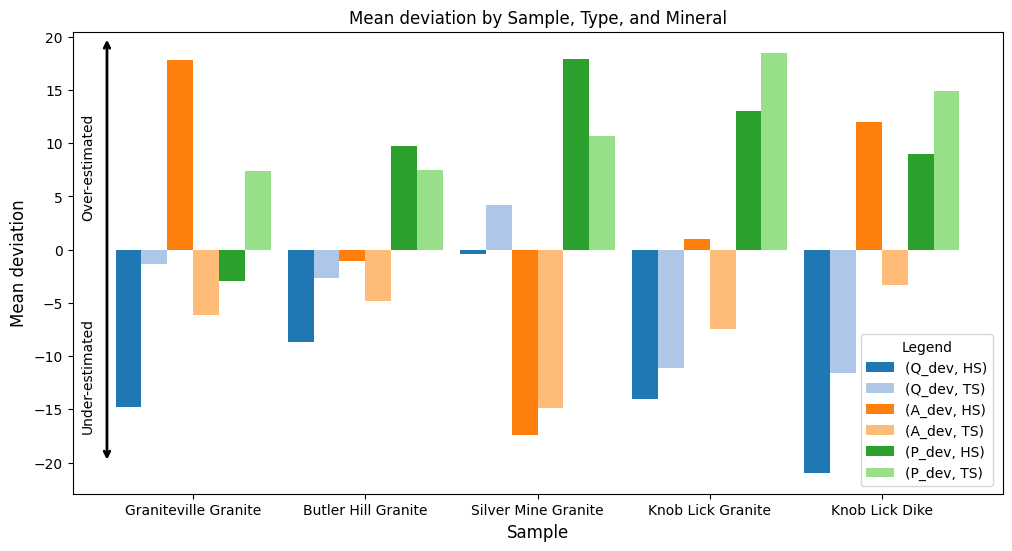

In [20]:
#this bar chart will show how students underestimate or overestimate specific minerals
fig_bar_1, ax_bar_1 = plt.subplots(figsize=(12, 6))
my_cols = plt.get_cmap('tab20').colors[:6] #this needed for plausible colors
HT_vs_TS.plot(ax=ax_bar_1, kind='bar', width=0.9, color = my_cols, legend = False) #bar chart for pandas dataframe
ax_bar_1.annotate('', xy=(-0.5, 20), xytext=(-0.5, -20), arrowprops=dict(arrowstyle='<->', color='black', linewidth=2))
ax_bar_1.text(-.65, 3, 'Over-estimated', rotation=90)
ax_bar_1.text(-.65, -17, 'Under-estimated', rotation=90)
ax_bar_1.legend(title = 'Legend', loc = 'upper left', frameon=True, bbox_to_anchor=(0.84, 0.36)) #that was a little struggle to fit legend inside of the plot
plt.ylabel("Mean deviation")
plt.title("Mean deviation by Sample, Type, and Mineral")
plt.xticks(rotation=0)
#plt.savefig("mineral_deviation.svg")
plt.show()

In [21]:
#let's estimate how good students are
student_eval = student_errors_df
#this is mean absolute deviation per mineral per student, separated by type of sample (Hand Sample or Thin Section)
student_eval[['Q_loss', 'A_loss', 'P_loss']] = student_eval[['Q_dev', 'A_dev', 'P_dev']].abs()
student_eval = (
    student_eval.groupby(["Student", "type"])
    .mean(numeric_only=True)[['Q_loss', 'A_loss', 'P_loss']]
    .reset_index()
    .pivot(index='Student', columns='type', values=['Q_loss', 'A_loss', 'P_loss']))
#this is summarized loss by student in TS and HS
student_eval_loss = pd.DataFrame({'TS loss': student_eval.xs('TS', axis = 1, level=1).mean(axis=1),
                                    'HS loss': student_eval.xs('HS', axis = 1, level=1).mean(axis=1)})
print(student_eval_loss)

           TS loss    HS loss
Student                      
A        42.855983  41.461279
B         6.936027  17.379252
C        17.204040  21.803367
D        20.134126  15.779732
E        11.495807  15.041847
F         8.883856  10.899167
G        10.698346  10.724738
H        10.951713  10.413626
I         7.547792   6.995632
J        20.896811        NaN
K         4.926597        NaN
L         8.758673        NaN
M         7.501037        NaN


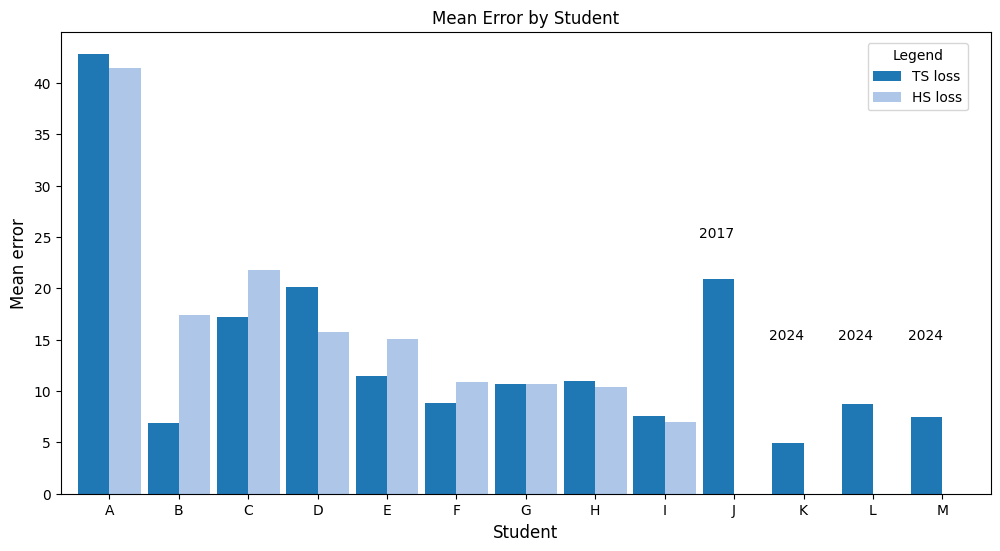

In [22]:
#this bar chart will show how how good specific students in mineral estimation
fig_bar_2, ax_bar_2 = plt.subplots(figsize=(12, 6))
student_eval_loss.plot(ax=ax_bar_2, kind='bar', width=0.9, color = my_cols) #bar chart for pandas dataframe
ax_bar_2.legend(title = 'Legend', loc = 'upper left', frameon=True, bbox_to_anchor=(0.86, 0.99))
ax_bar_2.text(x = 8.5, y=25, s = '2017')
ax_bar_2.text(x = 9.5, y=15, s = '2024')
ax_bar_2.text(x = 10.5, y=15, s = '2024')
ax_bar_2.text(x = 11.5, y=15, s = '2024')
plt.ylabel("Mean error")
plt.title("Mean Error by Student")
plt.xticks(rotation=0)
#plt.savefig("student_error.svg")
plt.show()